## Imports

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from xgboost import XGBClassifier

## Chargement du dataset

On charge le dataset et on retire les lignes ou il manque des données

In [37]:
df = pd.read_csv('dataset_V2.csv')
df = df.dropna(inplace=False)

In [38]:
df

,Date,MatchWeek,HomeTeam,AwayTeam,FTR,HomeYellowlMade,AwayYellowMade,HomeRedMade,AwayRedMade,HomeFoulMade,...,Home5GW,Home3GL,Home5GL,Away3GW,Away5GW,Away3GL,Away5GL,WHH,WHD,WHA
0,19/08/00,1,Charlton,Man City,H,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2.10,3.20,3.10
1,19/08/00,1,Chelsea,West Ham,H,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1.44,3.60,6.50
2,19/08/00,1,Coventry,Middlesbrough,A,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2.30,3.20,2.62
3,19/08/00,1,Derby,Southampton,D,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2.00,3.20,3.20
4,19/08/00,1,Leeds,Everton,H,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1.61,3.50,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31001,14/05/2022,34,Mainz,Ein Frankfurt,D,60.0,61.0,4.0,1.0,487.0,...,0,0,0,0,0,0,0,1.62,4.33,4.75
31002,14/05/2022,34,M'gladbach,Hoffenheim,H,66.0,73.0,1.0,0.0,350.0,...,0,0,0,0,0,0,0,2.05,4.20,3.00
31003,14/05/2022,34,Stuttgart,FC Koln,H,63.0,64.0,2.0,1.0,353.0,...,0,0,0,1,0,0,0,2.15,3.90,3.00
31004,14/05/2022,34,Union Berlin,Bochum,H,60.0,53.0,1.0,2.0,411.0,...,0,0,0,0,0,0,0,1.38,4.80,7.50


On groupe les résultats des matchs et on garde aléatoirement le même nombre de victoires, matchs nuls et défaites

In [39]:
groupes = df.groupby('FTR')
taille_echantillon = min([len(groupe) for _, groupe in groupes])
df = pd.concat([groupe.sample(taille_echantillon) for _, groupe in groupes])

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [41]:
df

,Date,MatchWeek,HomeTeam,AwayTeam,FTR,HomeYellowlMade,AwayYellowMade,HomeRedMade,AwayRedMade,HomeFoulMade,...,Home5GW,Home3GL,Home5GL,Away3GW,Away5GW,Away3GL,Away5GL,WHH,WHD,WHA
7469,2022-02-26,25,Leeds,Tottenham,A,68.0,42.0,1.0,1.0,275.0,...,0,0,0,0,0,1,0,3.80,3.75,1.88
26391,2007-05-05,32,Hamburg,Bochum,A,58.0,56.0,7.0,3.0,662.0,...,0,0,0,0,0,0,0,1.80,3.10,4.00
5496,2016-12-26,18,Swansea,West Ham,A,26.0,38.0,0.0,2.0,201.0,...,0,0,0,0,0,0,0,2.70,3.30,2.70
1565,2006-09-17,5,Man United,Arsenal,A,5.0,5.0,0.0,0.0,51.0,...,0,0,0,0,0,0,0,1.83,3.00,4.00
20276,2021-11-28,14,Milan,Sassuolo,A,26.0,32.0,1.0,0.0,167.0,...,0,0,0,0,0,0,0,1.55,4.33,5.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,2013-10-27,9,Sunderland,Newcastle,H,11.0,13.0,1.0,2.0,91.0,...,0,1,1,0,0,0,0,2.90,3.00,2.62
21196,2009-04-04,30,Valenciennes,Auxerre,H,58.0,36.0,3.0,1.0,547.0,...,0,0,0,0,0,0,0,2.15,2.88,3.25
23590,2015-08-28,4,Guingamp,Marseille,H,7.0,4.0,0.0,1.0,45.0,...,0,0,0,0,0,0,0,3.80,3.25,2.05
9626,2010-11-28,13,Santander,La Coruna,H,31.0,23.0,2.0,1.0,212.0,...,0,0,0,0,0,0,0,2.25,3.20,3.30


On retire certains paramètres

In [42]:
df_equipe = df[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'WHH', 'WHD', 'WHA']]
df = df.drop(['Date', 'HomeTeam', 'AwayTeam', 'FTR','HomeFormPtsStr','AwayFormPtsStr','MatchWeek'], axis=1)
df

,HomeYellowlMade,AwayYellowMade,HomeRedMade,AwayRedMade,HomeFoulMade,HomeFoulConceded,AwayFoulMade,AwayFoulConceded,HomeCornerMade,HomeCornerConceded,...,Home5GW,Home3GL,Home5GL,Away3GW,Away5GW,Away3GL,Away5GL,WHH,WHD,WHA
7469,68.0,42.0,1.0,1.0,275.0,253.0,244.0,267.0,113.0,119.0,...,0,0,0,0,0,1,0,3.80,3.75,1.88
26391,58.0,56.0,7.0,3.0,662.0,625.0,576.0,524.0,177.0,157.0,...,0,0,0,0,0,0,0,1.80,3.10,4.00
5496,26.0,38.0,0.0,2.0,201.0,194.0,200.0,212.0,83.0,90.0,...,0,0,0,0,0,0,0,2.70,3.30,2.70
1565,5.0,5.0,0.0,0.0,51.0,71.0,34.0,63.0,28.0,14.0,...,0,0,0,0,0,0,0,1.83,3.00,4.00
20276,26.0,32.0,1.0,0.0,167.0,180.0,168.0,187.0,53.0,63.0,...,0,0,0,0,0,0,0,1.55,4.33,5.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4267,11.0,13.0,1.0,2.0,91.0,86.0,85.0,75.0,42.0,43.0,...,0,1,1,0,0,0,0,2.90,3.00,2.62
21196,58.0,36.0,3.0,1.0,547.0,475.0,424.0,432.0,129.0,174.0,...,0,0,0,0,0,0,0,2.15,2.88,3.25
23590,7.0,4.0,0.0,1.0,45.0,45.0,32.0,32.0,16.0,11.0,...,0,0,0,0,0,0,0,3.80,3.25,2.05
9626,31.0,23.0,2.0,1.0,212.0,179.0,168.0,157.0,63.0,64.0,...,0,0,0,0,0,0,0,2.25,3.20,3.30


## Classification

La donnée à prédire est `FTR`, le résultat du match

In [43]:
X = df
y = df_equipe['FTR']

On remplace les valeurs textuelles du résultat par des chiffres

In [44]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
encoded_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

On split le dataset (80% train, 20% test) puis on échelonne les valeurs

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
test_index = X_test.index
X = X.astype(np.float32)
y = y.astype(np.float32)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Modèles de classification

Régression Logistique

In [ ]:
clf_RL = LogisticRegression(random_state=1)
clf_RL.fit(X_train, y_train)

y_pred_RL = clf_RL.predict(X_test)

accuracy_RL = clf_RL.score(X_test, y_test)
results = cross_validate(estimator=clf_RL,X=X,y=y,cv=5,scoring='accuracy')
accuracy_RL_cross = np.mean(results['test_score'])

Arbre Décisionel

In [47]:
clf_DT = DecisionTreeClassifier(random_state=1)
clf_DT.fit(X_train, y_train)

y_pred_DT = clf_DT.predict(X_test)

accuracy_DT = clf_DT.score(X_test, y_test)
results = cross_validate(estimator=clf_DT,X=X,y=y,cv=5,scoring='accuracy')
accuracy_DT_cross = np.mean(results['test_score'])

KNN

In [48]:
clf_KNN = KNeighborsClassifier(n_neighbors=8)
clf_KNN.fit(X_train, y_train)

y_pred_KNN = clf_KNN.predict(X_test)

accuracy_KNN = clf_KNN.score(X_test, y_test)
results = cross_validate(estimator=clf_KNN,X=X,y=y,cv=5,scoring='accuracy')
accuracy_KNN_cross = np.mean(results['test_score'])

Random Forest

In [49]:
clf_RF = RandomForestClassifier(random_state=1)
clf_RF.fit(X_train, y_train)

y_pred_RF = clf_RF.predict(X_test)

accuracy_RF = clf_RF.score(X_test, y_test)
results = cross_validate(estimator=clf_RF,X=X,y=y,cv=5,scoring='accuracy')
accuracy_RF_cross = np.mean(results['test_score'])

SVM

In [50]:
clf_SVM = SVC(kernel = 'rbf',random_state = 1)
clf_SVM.fit(X_train, y_train)

y_pred_SVM = clf_SVM.predict(X_test)

accuracy_SVM = clf_SVM.score(X_test, y_test)
results = cross_validate(estimator=clf_SVM,X=X,y=y,cv=3,scoring='accuracy')
accuracy_SVM_cross = np.mean(results['test_score'])

XGBoost

In [51]:
clf_XGB = XGBClassifier(seed=1)
clf_XGB.fit(X_train, y_train)

y_pred_XGB = clf_XGB.predict(X_test)

accuracy_XGB = clf_XGB.score(X_test, y_test)
results = cross_validate(estimator=clf_XGB,X=X,y=y,cv=5,scoring='accuracy')
accuracy_XGB_cross = np.mean(results['test_score'])

Réseau de Neurones

On définit le modèle séquentiel. Celui-ci contient `5 layers` avec un nombre de neurones décroissants. On ajoute des `Dropout` pour supprimer un certain pourcentage des neurones du layer précédent pour prévenir l'overfitting. Pour prévenir ce dernier, on utilise aussi la `L2 Regularization`. On a fait varier les focntions d'activation, le nombre d'epochs et le learning rate pour obtenir les meilleurs résultats possibles.

In [52]:
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(41,), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# Affichage d'un résumé du modèle
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10752     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                         

2023-03-24 19:57:36.085748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-24 19:57:36.085869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


On entraîne le modèle puis on affiche les loss du dataset d'entraînement et de validation selon le nombre d'epochs afin de repérer un éventuel overfitting

In [53]:
hist = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=2)
test_loss_RN, test_acc_RN = model.evaluate(X_test, y_test)
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']
epoch = range(1, len(training_loss) + 1)

Epoch 1/50


2023-03-24 19:57:36.313736: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-24 19:57:36.578137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-24 19:57:39.278412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


229/229 - 3s - loss: 1.7463 - accuracy: 0.4335 - val_loss: 1.4559 - val_accuracy: 0.4719 - 3s/epoch - 15ms/step
Epoch 2/50
229/229 - 2s - loss: 1.3555 - accuracy: 0.4537 - val_loss: 1.2569 - val_accuracy: 0.4724 - 2s/epoch - 11ms/step
Epoch 3/50
229/229 - 2s - loss: 1.2194 - accuracy: 0.4584 - val_loss: 1.1729 - val_accuracy: 0.4692 - 2s/epoch - 10ms/step
Epoch 4/50
229/229 - 3s - loss: 1.1523 - accuracy: 0.4664 - val_loss: 1.1255 - val_accuracy: 0.4591 - 3s/epoch - 12ms/step
Epoch 5/50
229/229 - 2s - loss: 1.1117 - accuracy: 0.4593 - val_loss: 1.0921 - val_accuracy: 0.4618 - 2s/epoch - 10ms/step
Epoch 6/50
229/229 - 2s - loss: 1.0849 - accuracy: 0.4636 - val_loss: 1.0699 - val_accuracy: 0.4681 - 2s/epoch - 10ms/step
Epoch 7/50
229/229 - 3s - loss: 1.0662 - accuracy: 0.4644 - val_loss: 1.0545 - val_accuracy: 0.4689 - 3s/epoch - 11ms/step
Epoch 8/50
229/229 - 3s - loss: 1.0547 - accuracy: 0.4625 - val_loss: 1.0497 - val_accuracy: 0.4713 - 3s/epoch - 11ms/step
Epoch 9/50
229/229 - 2s - l

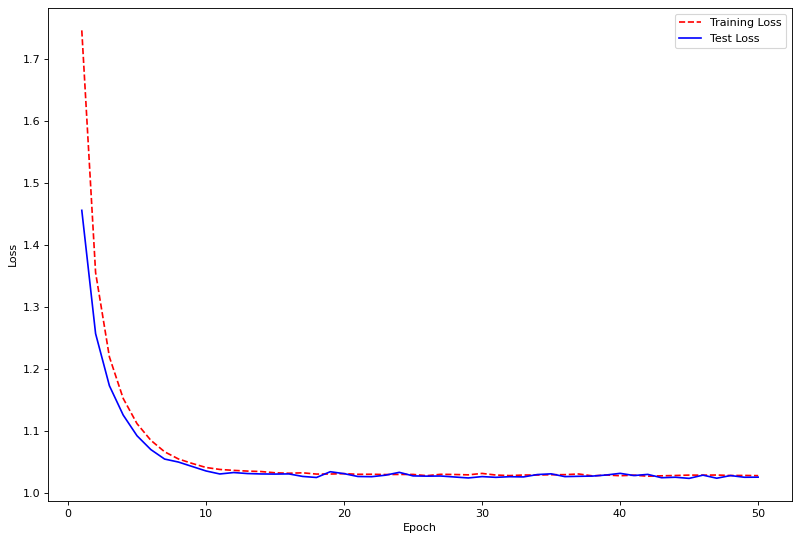

In [54]:
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epoch, training_loss, 'r--')
plt.plot(epoch, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

On réalise la KFold Cross Validation sur le réseau de neurones (On réduit le nombre d'epochs pour ne pas faire planter Python)

In [55]:
'''
X_np = X.to_numpy()
y_np = y

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cvscores = []
for train, test in kfold.split(X_np, y_np):
    model_KF = model
    model_KF.fit(X_np[train], y_np[train], epochs=10, batch_size=64, verbose = 2, validation_data=(X_np[test], y_np[test]))
    scores = model_KF.evaluate(X_np[test], y_np[test], verbose=0)
    cvscores.append(scores[1])

test_acc_RN_cross = np.mean(cvscores)
'''

'\nX_np = X.to_numpy()\ny_np = y\n\nkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)\ncvscores = []\nfor train, test in kfold.split(X_np, y_np):\n    model_KF = model\n    model_KF.fit(X_np[train], y_np[train], epochs=10, batch_size=64, verbose = 2, validation_data=(X_np[test], y_np[test]))\n    scores = model_KF.evaluate(X_np[test], y_np[test], verbose=0)\n    cvscores.append(scores[1])\n\ntest_acc_RN_cross = np.mean(cvscores)\n'

On réalise la prédiction sur le jeu de test

In [56]:
y_pred_RN = model.predict(X_test, verbose=0)
y_pred_RN = np.argmax(y_pred_RN, axis=1)

2023-03-24 19:59:38.319268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Statistiques

On affiche l'**accuracy** de chaque modèle

In [57]:
print("Accuracy du LogisticRegression:", accuracy_RL)
print("Accuracy du DecisionTreeClassifier:", accuracy_DT)
print("Accuracy du KNeighborsClassifier:", accuracy_KNN)
print("Accuracy du RandomForestClassifier:", accuracy_RF)
print("Accuracy du SVMClassifier:", accuracy_SVM)
print("Accuracy du XGBoostClassifier:", accuracy_XGB)
print("Accuracy du Réseau de Neurones:", test_acc_RN)

Accuracy du LogisticRegression: 0.4873362445414847
Accuracy du DecisionTreeClassifier: 0.3818777292576419
Accuracy du KNeighborsClassifier: 0.4237991266375546
Accuracy du RandomForestClassifier: 0.46004366812227077
Accuracy du SVMClassifier: 0.4759825327510917
Accuracy du XGBoostClassifier: 0.4441048034934498
Accuracy du Réseau de Neurones: 0.4838428199291229


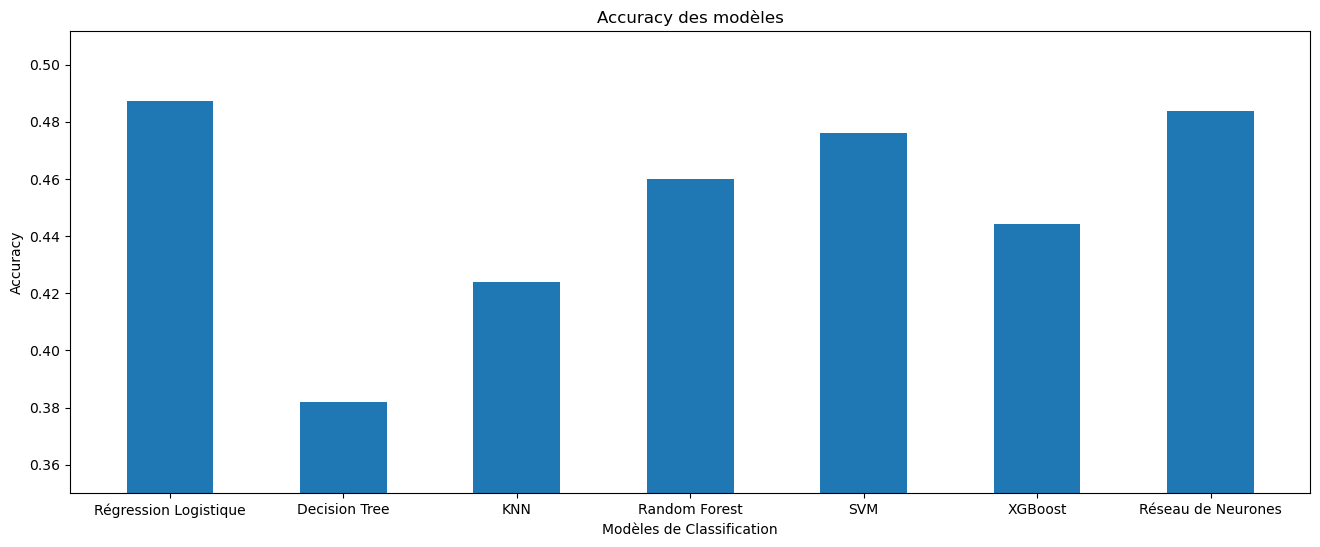

In [126]:
modeles = ['Régression Logistique', 'Decision Tree', 'KNN', 'Random Forest', 'SVM', 'XGBoost', 'Réseau de Neurones']
modeles_acc = [accuracy_RL, accuracy_DT, accuracy_KNN, accuracy_RF, accuracy_SVM, accuracy_XGB, test_acc_RN]

plt.figure(figsize=(16, 6))
plt.bar(x=modeles, height=modeles_acc, width=0.5, bottom=None, align='center')
plt.ylim(bottom=0.35)
plt.xlabel('Modèles de Classification')
plt.ylabel('Accuracy')
plt.title('Accuracy des modèles')
plt.show()

On affiche l'**accuracy** de chaque modèle après une KFold Cross Validation en 5 divisions

In [58]:
print('KFold Cross Validation')
print("Accuracy du LogisticRegression:", accuracy_RL_cross)
print("Accuracy du DecisionTreeClassifier:", accuracy_DT_cross)
print("Accuracy du KNeighborsClassifier:", accuracy_KNN_cross)
print("Accuracy du RandomForestClassifier:", accuracy_RF_cross)
print("Accuracy du SVMClassifier:", accuracy_SVM_cross)
print("Accuracy du XGBoostClassifier:", accuracy_XGB_cross)
#print("Accuracy du Réseau de Neurones:", test_acc_RN_cross)

KFold Cross Validation
Accuracy du LogisticRegression: 0.45531959553343493
Accuracy du DecisionTreeClassifier: 0.3876220280357165
Accuracy du KNeighborsClassifier: 0.4103770678939644
Accuracy du RandomForestClassifier: 0.45252413953581516
Accuracy du SVMClassifier: 0.45103948287910556
Accuracy du XGBoostClassifier: 0.44850598565122146


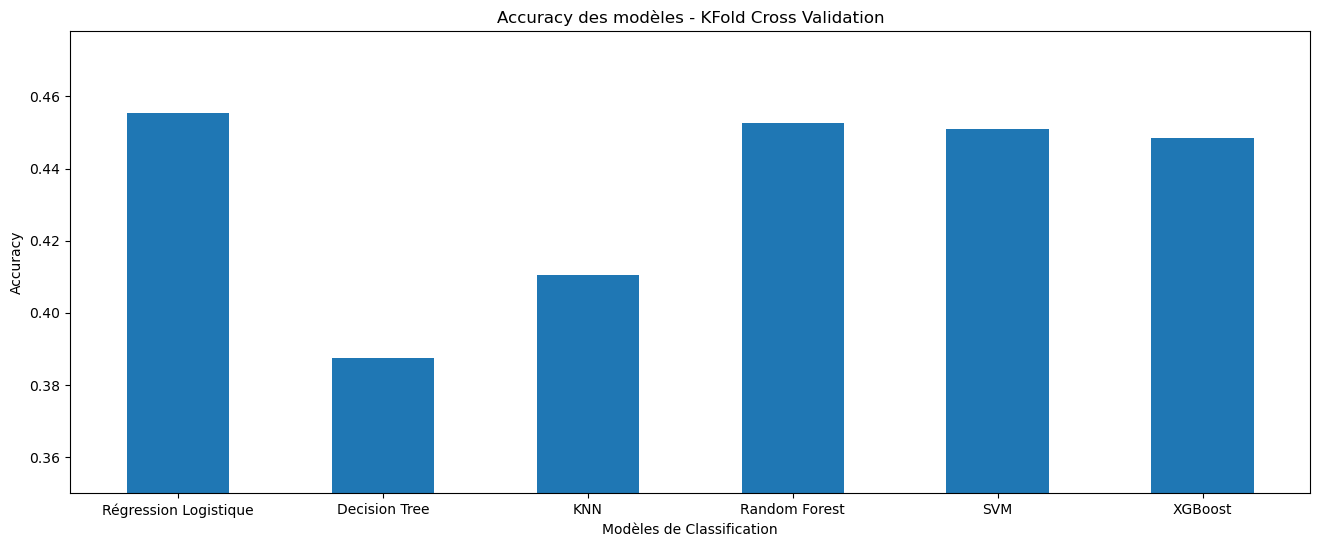

In [127]:
modeles = ['Régression Logistique', 'Decision Tree', 'KNN', 'Random Forest', 'SVM', 'XGBoost']#, 'Réseau de Neurones']
modeles_acc = [accuracy_RL_cross, accuracy_DT_cross, accuracy_KNN_cross, accuracy_RF_cross, accuracy_SVM_cross, accuracy_XGB_cross]#, test_acc_RN]

plt.figure(figsize=(16, 6))
plt.bar(x=modeles, height=modeles_acc, width=0.5, bottom=None, align='center')
plt.ylim(bottom=0.35)
plt.xlabel('Modèles de Classification')
plt.ylabel('Accuracy')
plt.title('Accuracy des modèles - KFold Cross Validation')
plt.show()

### Matrices de confusion

Régression Logistique

<Axes: >

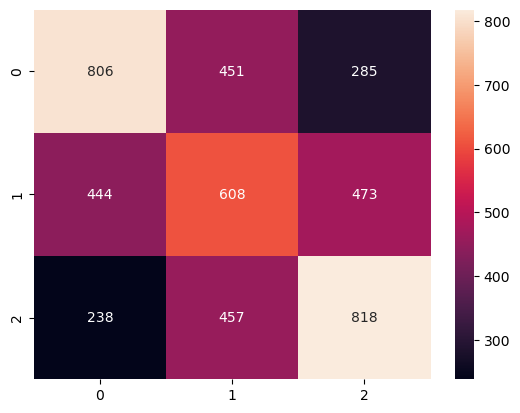

In [59]:
cm = confusion_matrix(y_test, y_pred_RL)
sns.heatmap(cm, annot=True, fmt='d')

Decision Tree

<Axes: >

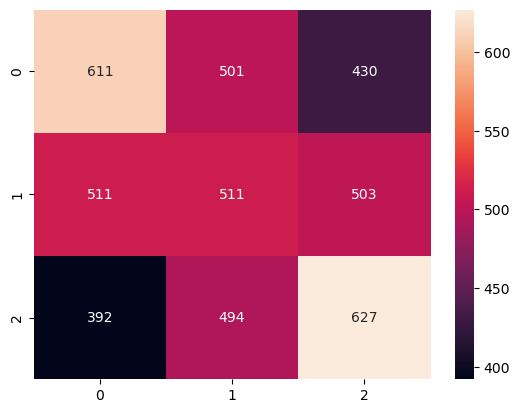

In [60]:
cm = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(cm, annot=True, fmt='d')

KNN

<Axes: >

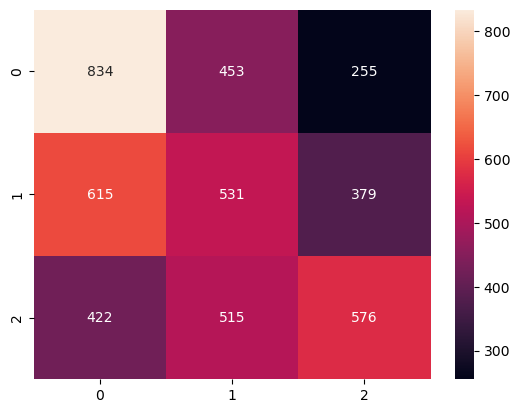

In [61]:
cm = confusion_matrix(y_test, y_pred_KNN)
sns.heatmap(cm, annot=True, fmt='d')

Random Forest

<Axes: >

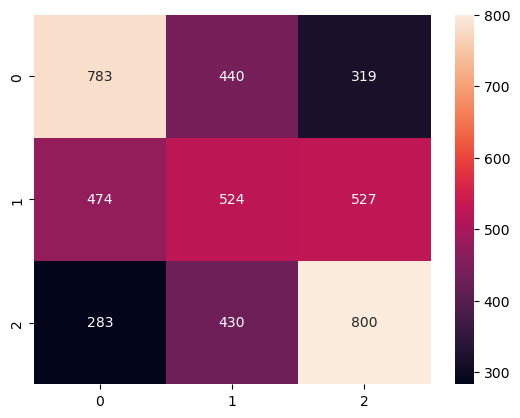

In [62]:
cm = confusion_matrix(y_test, y_pred_RF)
sns.heatmap(cm, annot=True, fmt='d')

SVM

<Axes: >

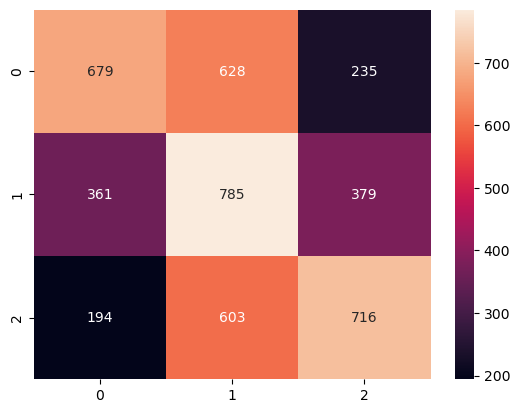

In [64]:
cm = confusion_matrix(y_test, y_pred_SVM)
sns.heatmap(cm, annot=True, fmt='d')

XGBoost

<Axes: >

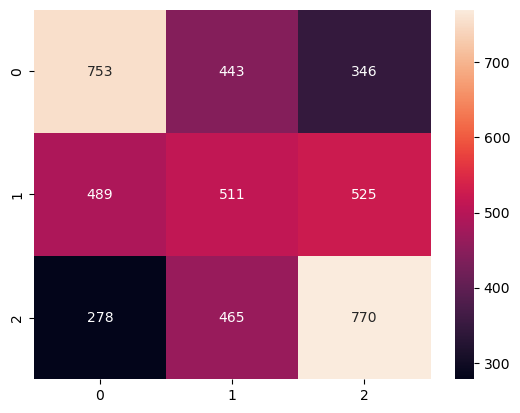

In [65]:
cm = confusion_matrix(y_test, y_pred_XGB)
sns.heatmap(cm, annot=True, fmt='d')

Réseau de Neurones

<Axes: >

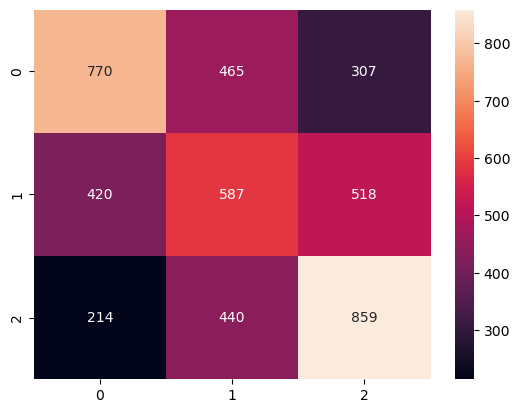

In [66]:
cm = confusion_matrix(y_test, y_pred_RN)
sns.heatmap(cm, annot=True, fmt='d')

### Importance des features

On affiche l'imortance de chaque feature pour chaque modèle

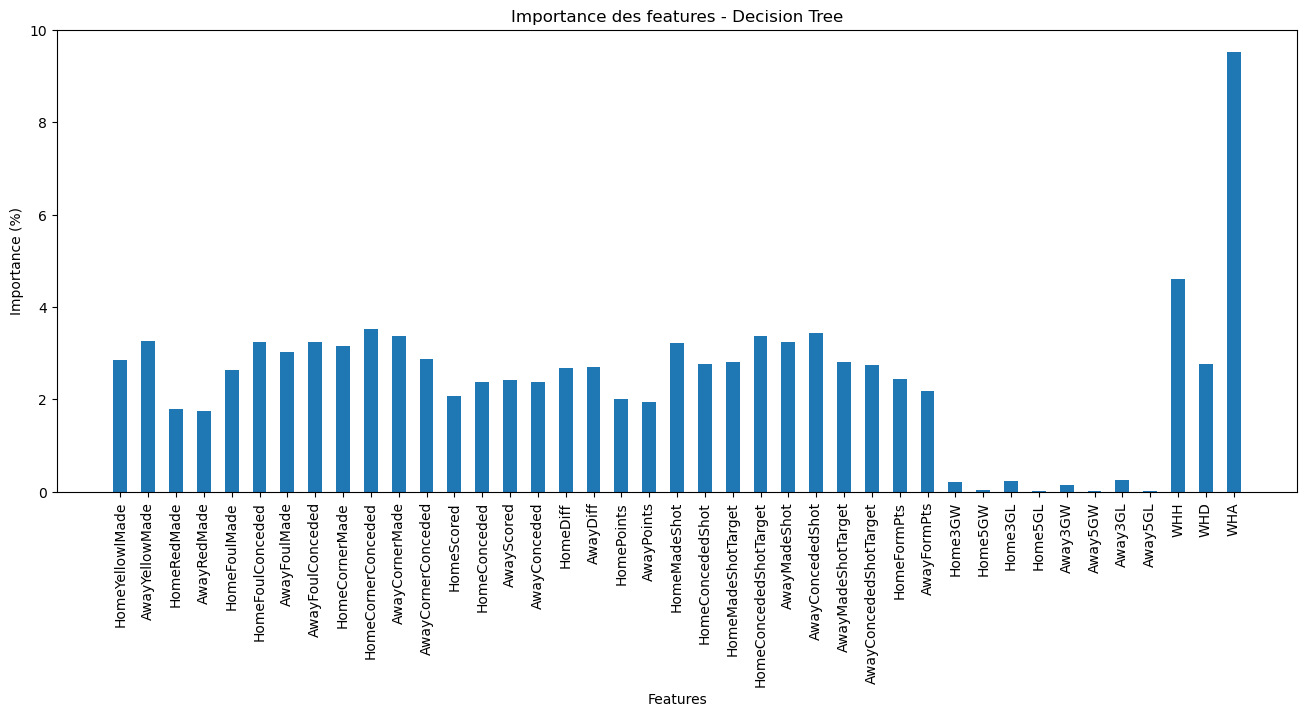

In [112]:
plt.figure(figsize=(16, 6))
plt.bar(x=df.columns,height=clf_DT.feature_importances_*100,width=0.5,bottom=None, align='center')
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.title('Importance des features - Decision Tree')
plt.show()

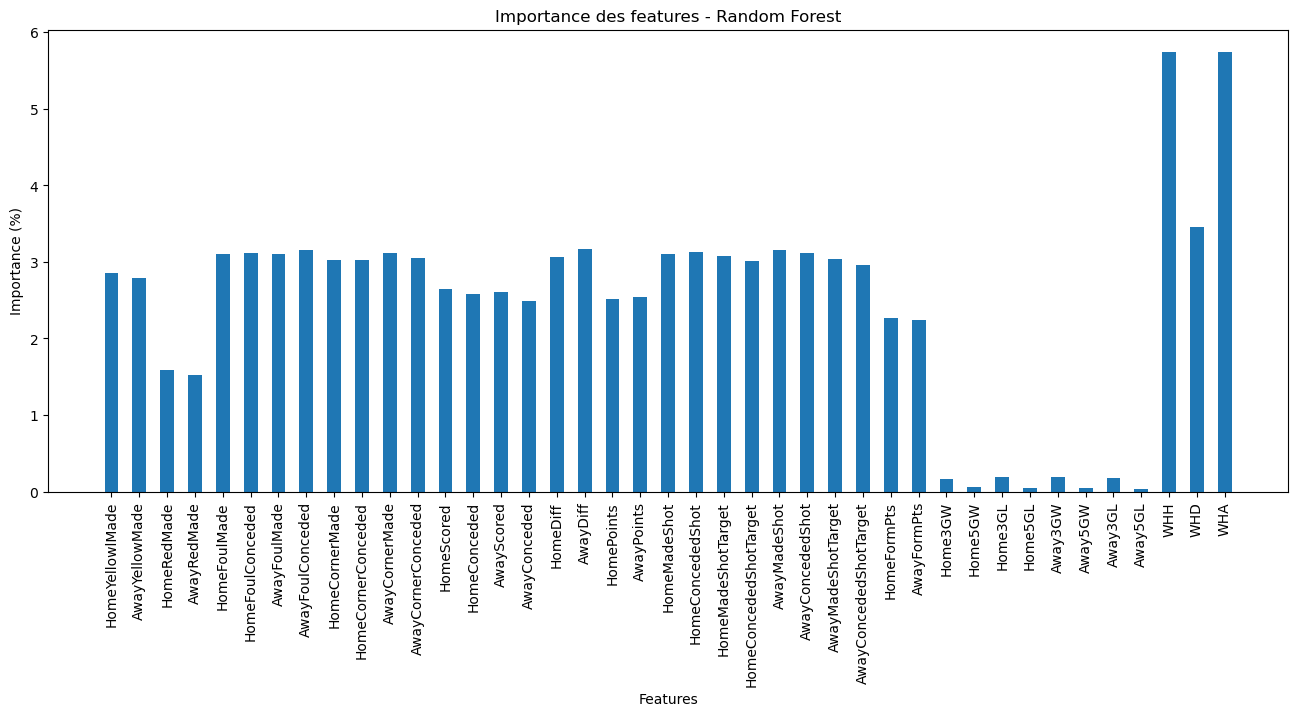

In [115]:
plt.figure(figsize=(16, 6))
plt.bar(x=df.columns,height=clf_RF.feature_importances_*100,width=0.5,bottom=None, align='center')
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.title('Importance des features - Random Forest')
plt.show()

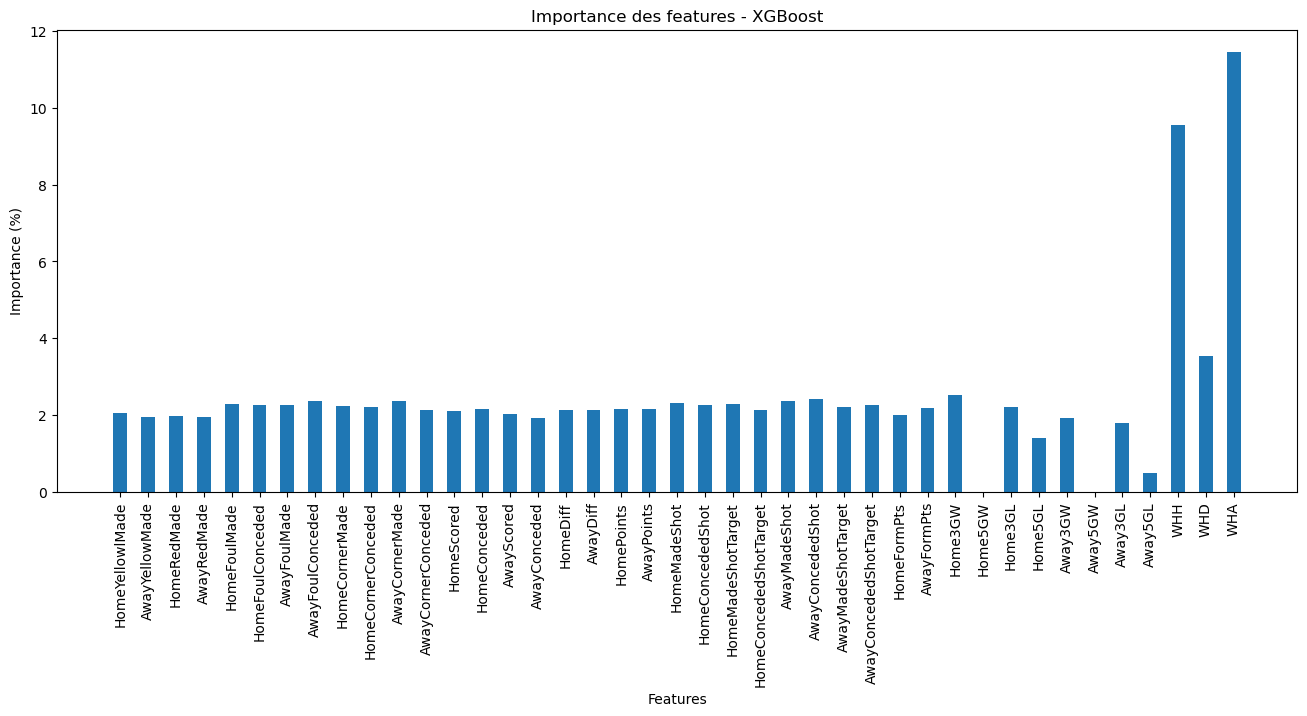

In [118]:
plt.figure(figsize=(16, 6))
plt.bar(x=df.columns,height=clf_XGB.feature_importances_*100,width=0.5,bottom=None, align='center')
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.title('Importance des features - XGBoost')
plt.show()

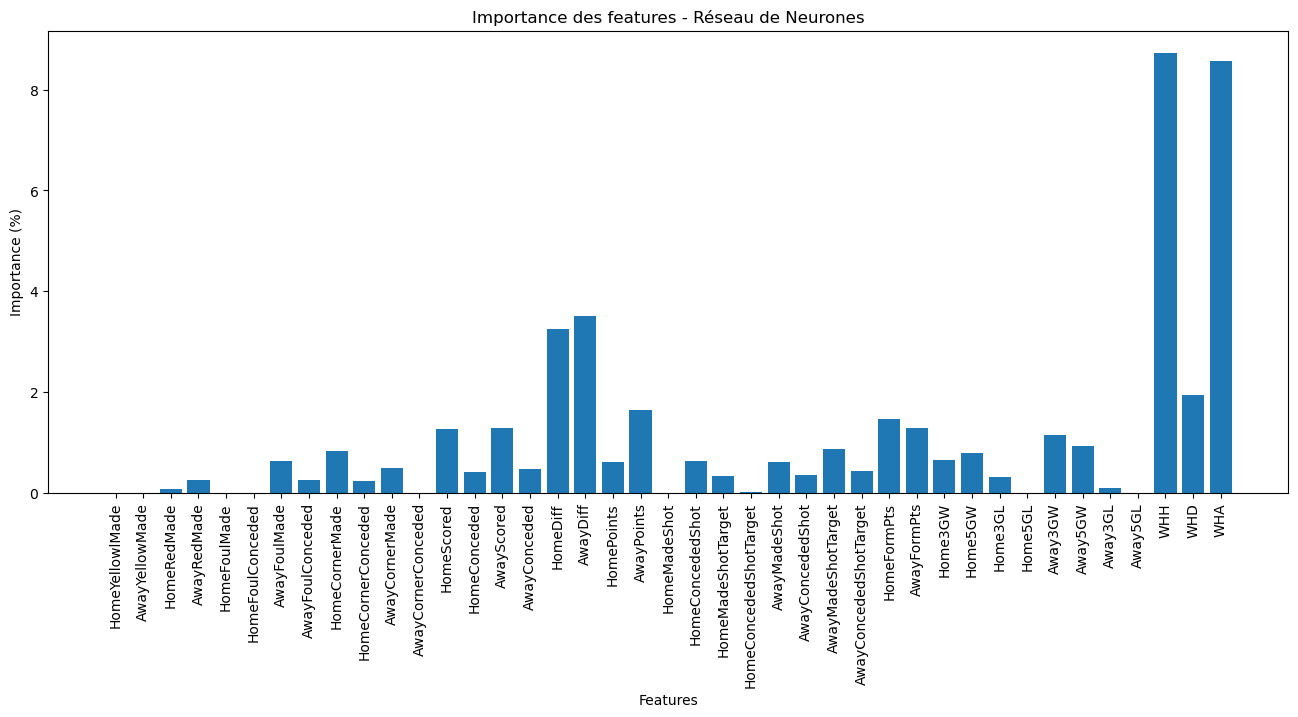

In [121]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(100*fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

plt.figure(figsize=(16, 6))
plt.bar(x=featureScores['Specs'], height=featureScores['Score'])
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.title('Importance des features - Réseau de Neurones')
plt.show()

## Résultats Financiers

### Gains toutes saisons confondues

Fonction calculant le gain par modèle si on se fie à ses prédictions en misant sur chaque match une somme `mise`.

Le gain est calculé en retirant la mise initiale, pour ne garder que le profit.

In [134]:
def calculgain(mise, pred):
    df_final = pd.DataFrame()
    df_final['Résultat'] = y_test
    df_final['Prédiction'] = pred
    df_final.index = test_index
    df_final = pd.merge(df_equipe[['WHH','WHD','WHA']].reset_index(), df_final.reset_index(), on='index')
    df_final['Résultat'] = df_final['Résultat'].astype('int')
    df_final = df_final.drop(['index'], axis=1)

    gain = []
    cote = []
    for index, _ in df_final.iterrows():
        if df_final.iloc[index]['Résultat'] == df_final.iloc[index]['Prédiction']:
            if df_final.iloc[index]['Résultat'] == encoded_dict['H']:
                gain.append(mise*df_final.iloc[index]['WHH']-mise)
                cote.append(df_final.iloc[index]['WHH'])
            if df_final.iloc[index]['Résultat'] == encoded_dict['D']:
                gain.append(mise*df_final.iloc[index]['WHD']-mise)
                cote.append(df_final.iloc[index]['WHD'])
            if df_final.iloc[index]['Résultat'] == encoded_dict['A']:
                gain.append(mise*df_final.iloc[index]['WHA']-mise)
                cote.append(df_final.iloc[index]['WHA'])
        else:
            gain.append(-10)

    print(f'Somme gagnée en misant {mise}€ sur chaque match : {round(sum(gain),2)}€')
    print(f'Somme gagnée par match : {round(np.mean(gain),2)}€')
    print(f'Moyenne des cotes validées : {round(np.mean(cote),2)}')
    print(f'Nombre de paris validés : {len(cote)} / {len(pred)}')

On affiche les gains pour chaque modèle

In [135]:
mise = 10

print('LogisticRegressionClassifier :')
calculgain(mise, y_pred_RL)
print()
print('DecisionTreeClassifier :')
calculgain(mise, y_pred_DT)
print()
print('KNeighborsClassifier :')
calculgain(mise, y_pred_KNN)
print()
print('RandomForestClassifier :')
calculgain(mise, y_pred_RF)
print()
print('SVMClassifier :')
calculgain(mise, y_pred_SVM)
print()
print('XGBoostClassifier :')
calculgain(mise, y_pred_XGB)
print()
print('Réseau de Neurones :')
calculgain(mise, y_pred_RN)

LogisticRegressionClassifier :
Somme gagnée en misant 10€ sur chaque match : 1725.2€
Somme gagnée par match : 0.38€
Moyenne des cotes validées : 2.13
Nombre de paris validés : 2232 / 4580

DecisionTreeClassifier :
Somme gagnée en misant 10€ sur chaque match : -2407.4€
Somme gagnée par match : -0.53€
Moyenne des cotes validées : 2.48
Nombre de paris validés : 1749 / 4580

KNeighborsClassifier :
Somme gagnée en misant 10€ sur chaque match : 428.7€
Somme gagnée par match : 0.09€
Moyenne des cotes validées : 2.38
Nombre de paris validés : 1941 / 4580

RandomForestClassifier :
Somme gagnée en misant 10€ sur chaque match : -732.1€
Somme gagnée par match : -0.16€
Moyenne des cotes validées : 2.14
Nombre de paris validés : 2107 / 4580

SVMClassifier :
Somme gagnée en misant 10€ sur chaque match : 2563.5€
Somme gagnée par match : 0.56€
Moyenne des cotes validées : 2.22
Nombre de paris validés : 2180 / 4580

XGBoostClassifier :
Somme gagnée en misant 10€ sur chaque match : -1922.5€
Somme gagnée 

### Gains par saison

On affiche les gains réalisés par saison pour chaque modèle de classification

In [90]:
def calculgainsaison(mise, pred, titre):
    df_final = pd.DataFrame()
    df_final['Résultat'] = y_test
    df_final['Prédiction'] = pred
    df_final.index = test_index
    df_final = pd.merge(df_equipe[['Date','WHH','WHD','WHA']].reset_index(), df_final.reset_index(), on='index')
    df_final['Résultat'] = df_final['Résultat'].astype('int')
    df_final = df_final.drop(['index'], axis=1)

    index_saison = []
    gain_saison = []
    cote_saison = []

    for i in range(22):
        new_df = df_final.copy()
        new_df = df_final.loc[(df_final['Date']>='20'+str(i).zfill(2)+'-08-04') & (df_final['Date']<='20'+str(i+1).zfill(2)+'-08-03')]
        index_saison.append('20'+str(i).zfill(2)+'/20'+str(i+1).zfill(2))
        new_df = new_df.reset_index(drop=True)
        gain = []
        cote = []
        for index, _ in new_df.iterrows():
            if new_df.iloc[index]['Résultat'] == new_df.iloc[index]['Prédiction']:
                if new_df.iloc[index]['Résultat'] == encoded_dict['H']:
                    gain.append(mise*new_df.iloc[index]['WHH']-mise)
                    cote.append(new_df.iloc[index]['WHH'])
                if new_df.iloc[index]['Résultat'] == encoded_dict['D']:
                    gain.append(mise*new_df.iloc[index]['WHD']-mise)
                    cote.append(new_df.iloc[index]['WHD'])
                if new_df.iloc[index]['Résultat'] == encoded_dict['A']:
                    gain.append(mise*new_df.iloc[index]['WHA']-mise)
                    cote.append(new_df.iloc[index]['WHA'])
            else:
                gain.append(-10)
        gain_saison.append(round(sum(gain),2))
        cote_saison.append(round(np.mean(cote),2))
    
    plt.bar(x=index_saison, height=gain_saison, color=['green' if gain >= 0 else 'red' for gain in gain_saison])
    plt.xlabel('Saison')
    plt.ylabel('Résultat en €')
    plt.xticks(rotation=60)
    plt.title(titre)
    plt.show()

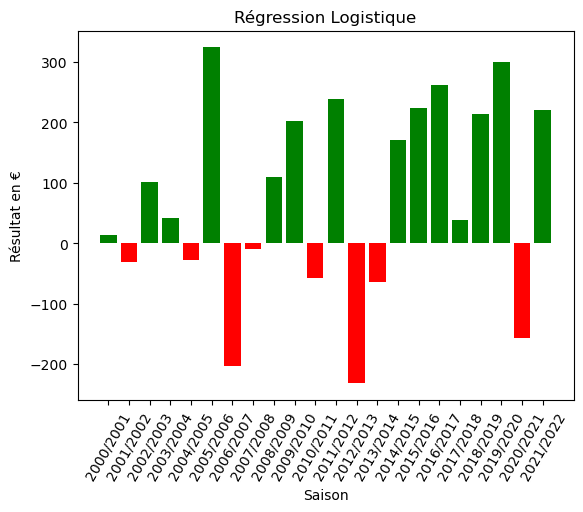

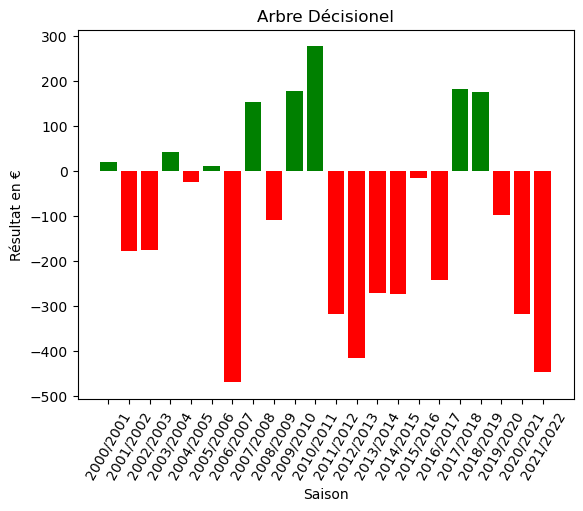

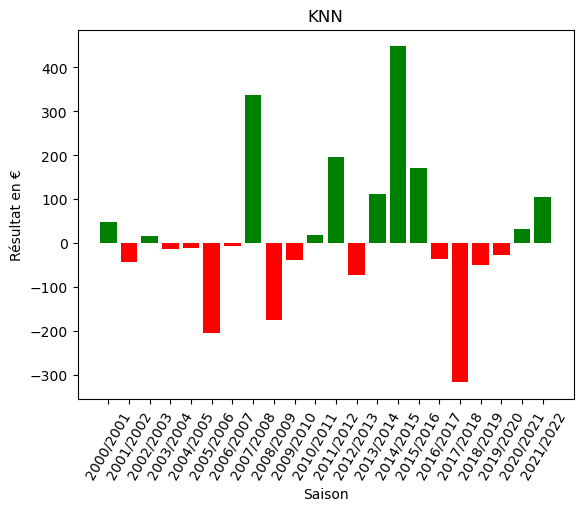

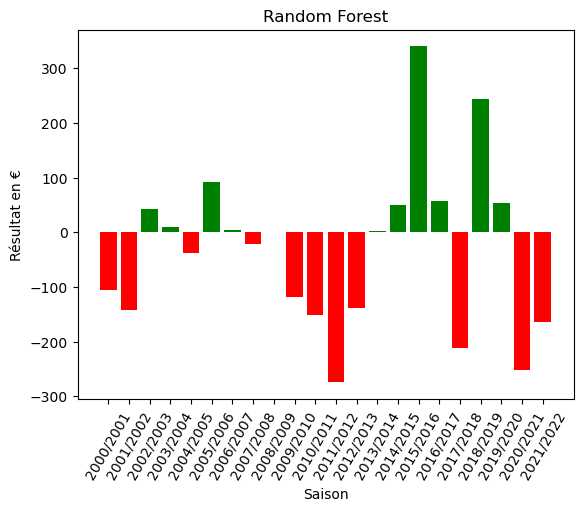

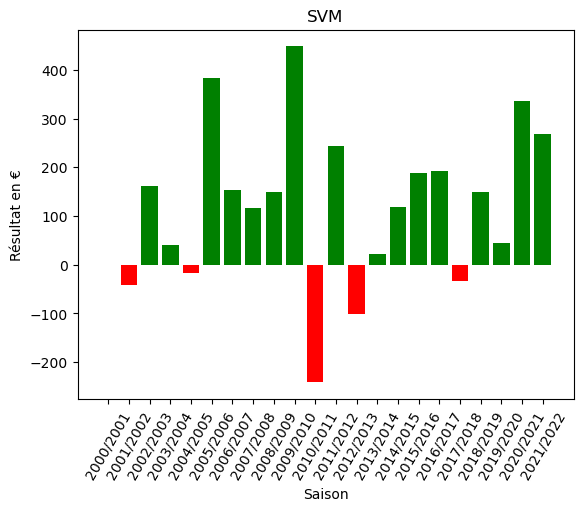

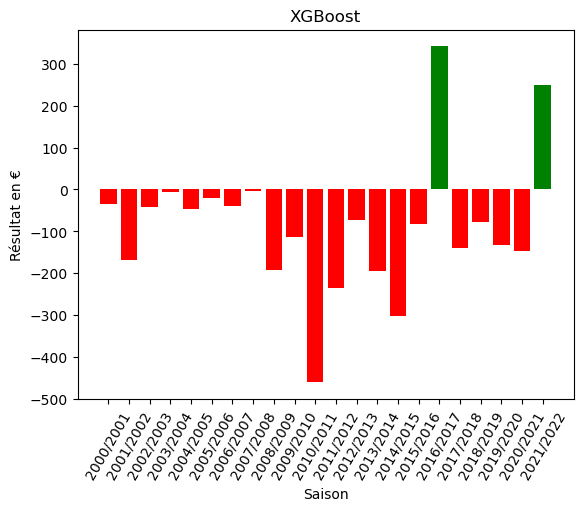

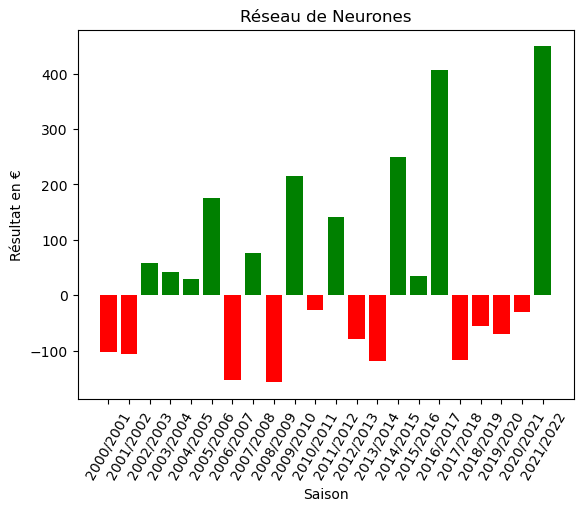

In [91]:
calculgainsaison(mise, y_pred_RL, 'Régression Logistique')
calculgainsaison(mise, y_pred_DT, 'Arbre Décisionel')
calculgainsaison(mise, y_pred_KNN, 'KNN')
calculgainsaison(mise, y_pred_RF, 'Random Forest')
calculgainsaison(mise, y_pred_SVM, 'SVM')
calculgainsaison(mise, y_pred_XGB, 'XGBoost')
calculgainsaison(mise, y_pred_RN, 'Réseau de Neurones')